In [1]:
import pandas as pd
import numpy as np
import os
import folium
from folium import plugins
import webbrowser
import chardet
from datetime import datetime

# rawdata = ""
# with open('2021_MCM_Problem_C_Data/2021MCMProblemC_DataSet.xlsx', 'r') as f:
#     rawdata += f.readline()

# chardet.detect(rawdata)

data = pd.read_excel("2021_MCM_Problem_C_Data/2021MCMProblemC_DataSet.xlsx", datetime = "Detection Date")

for i in range(0, len(data)) :
    if(isinstance(data.iloc[i]["Detection Date"], datetime)) : 
        data.loc[i, "Detection Date"] = data.iloc[i]["Detection Date"].year
    else :
        data.loc[i, "Detection Date"] = np.nan

PosData2020 = data[(data["Detection Date"] == 2020) & (data["Lab Status"] == "Positive ID")]

PosData2019 = data[(data["Detection Date"] == 2019) & (data["Lab Status"] == "Positive ID")]

In [2]:
print("2019: {0} : {1}".format(PosData2019["Latitude"].mean(), PosData2019["Longitude"].mean()))

print("2020: {0} : {1}".format(PosData2020["Latitude"].mean(), PosData2020["Longitude"].mean()))

2019: 49.024412000000005 : -122.96909459999999
2020: 48.959598666666665 : -122.59492977777775


In [3]:
import matplotlib.pyplot as plt
from bokeh.plotting import figure, save
from bokeh.models import GeoJSONDataSource
import webbrowser
import json
import math
import copy

with open("us-all-mainland.geo.json", encoding="utf8") as f:
    temp_data = json.loads(f.read())

PosData2020.loc[:, "x"] = PosData2020["Longitude"]

PosData2020.loc[:, "y"] = PosData2020["Latitude"]

PosData2019.loc[:, "x"] = PosData2019["Longitude"]

PosData2019.loc[:, "y"] = PosData2019["Latitude"]

def isInWA(district):
    if 'woe-name' in district['properties'] and 'Washington' in district['properties']['woe-name']:
        return True
    
    return False

temp_data['features'] = list(filter(isInWA, temp_data['features']))

Interval_Lat = 111.11

Interval_Long = 111.11 * np.cos((50 + 45) / 2 / 180 * 3.1415926)

L = 25

WA_Latitude_range = np.arange(45, 50, L / Interval_Lat)

WA_Longitude_range = np.arange(116, 125, L / Interval_Long)

dp_array = np.zeros(shape = (len(WA_Longitude_range), len(WA_Latitude_range)))

WA_geo_source = GeoJSONDataSource(geojson=json.dumps(temp_data))

# p = figure(width=500, height=500)

# p.scatter(PosData2020["x"], PosData2020["y"], color = "blue")

# p.scatter(PosData2019["x"], PosData2019["y"], color = "red")

# for x in WA_Longitude_range :
#     p.line([x, x], [WA_Latitude_range[0], WA_Latitude_range[-1]])

# for y in WA_Latitude_range :
#     p.line([WA_Longitude_range[0], WA_Longitude_range[-1]], [y, y], color = "black")

# p.patches(xs='xs', ys='ys', source=WA_geo_source)

# save(obj=p, filename="WA_Map.html")

# webbrowser.open("WA_Map.html")

C:\Users\uzuki\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\uzuki\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [4]:
def get_index(long, lat) :
    return int((long - WA_Longitude_range[0]) / (L / Interval_Long)), int((lat - WA_Latitude_range[0]) / (L / Interval_Lat))

def distance(long1, lat1, long2, lat2) :
    return np.sqrt(np.power(long1-long2, 2) + np.power(lat1 - lat2, 2))
#     return math.acos(math.sin(lat1) * math.sin(lat2) + math.cos(lat1) * math.cos(lat2) * math.cos(long1 - long2))

def probability(long1, lat1, long2, lat2, gamma) :
    return 1 / (1 + np.power(distance(long1, lat1, long2, lat2) / gamma, 2))

In [5]:
from scipy.optimize import leastsq

def initBlock(block, data, long = "x", lat = "y") :
    for x, y in zip(data[long], data[lat]) :
        block[get_index(-x, y)] += 1

def add_point(long, lat) :
    for i in range(0, len(city)) :
        dis = distance(long, lat, city[i][0], city[i][1])
        if(dis <= city_radius[i]) : city_size[i] += 1
        
gamma = 1
        
def evaluation(dp_array) :
    
    dp_array_copy = copy.deepcopy(dp_array)
    
    for i in range(0, len(WA_Longitude_range)) :
        for j in range(0, len(WA_Latitude_range)) :
            Lat1, Long1 = WA_Latitude_range[j], -WA_Longitude_range[i]
            p = np.zeros(shape = (len(WA_Longitude_range), len(WA_Latitude_range)))
            if(dp_array[i][j] <= 0) : continue
            for k in range(0, len(WA_Longitude_range)) :
                for l in range(0, len(WA_Latitude_range)) :
                    Lat2, Long2 = WA_Latitude_range[l], -WA_Longitude_range[k]
                    p[k][l] = probability(Long1, Lat1, Long2, Lat2, gamma)
            p /= p.sum()
            for k in range(0, len(WA_Longitude_range)) :
                for l in range(0, len(WA_Latitude_range)) :
                    Lat2, Long2 = WA_Latitude_range[l], -WA_Longitude_range[k]
                    dp_array_copy[k][l] = p[k][l] * dp_array[i][j]
    return dp_array_copy

# reproduce_ratio

def MSE(gamma, dp_array, dp) :
    
    dp2 = evaluation1(dp_array, gamma)
    
    return np.sqrt(np.power(dp2 - dp, 2).sum())

def evaluation1(dp_array, gamma) :
    
    dp_array_copy = [0] * len(dp_array)

    for i in range(0, len(dp_array)) :
        for j in range(0, len(dp_array)) :
            d = distance(city[i][0], city[i][1], city[j][0], city[j][1])
            dp_array_copy[j] += dp_array[i] * (1 / (1 + np.power(d/gamma, 2)))
            
    return dp_array_copy

In [22]:
from scipy.optimize import leastsq

# initBlock(dp_array, PosData2020)

# initBlock(dp_array, PosData2019)

from sklearn.cluster import KMeans
city_KMenas_Ins = KMeans(n_clusters = 12).fit(data[["Longitude", "Latitude"]])
city = city_KMenas_Ins.cluster_centers_
pointType = city_KMenas_Ins.predict(data[["Longitude", "Latitude"]])
city_radius = [0] * len(city)
city_size = [0] * len(city)
for i in range(0, len(city)) :
    city_radius[i] = np.apply_along_axis(lambda x : distance(x[0], x[1], city[i][0], city[i][1]),1 ,data[pointType == i][["Longitude", "Latitude"]]).max()
    
for i in range(0, len(PosData2019)) :
    point = PosData2019.iloc[i]
    add_point(point["x"], point["y"])
    
print(city_size)

city_size_2019 = city_size
    
city_size = [0] * len(city)

for i in range(0, len(PosData2020)) :
    point = PosData2020.iloc[i]
    add_point(point["x"], point["y"])
    
print(city_size)

print(city_radius)

print(MSE(1, np.array(city_size_2019), np.array(city_size)))

gamma = leastsq(MSE, 1,args=(np.array(city_size_2019), np.array(city_size)))

print(MSE(gamma[0][0], np.array(city_size_2019), np.array(city_size)))

print(gamma[0][0])

curve = []

[0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0]
[1.1327960846406075, 1.118610615253852, 1.4391663040248446, 0.9410526916791438, 1.32562663215229, 1.3430116473855633, 1.4144916630285895, 1.5931369984903672, 0.9433414644155261, 1.022414199102953, 1.0644866542627192, 1.1538062965830684]
5.931536749286547
5.186485066297495
-0.5449295266864411


In [79]:
import folium
from folium.plugins import HeatMap

Display_latitude = PosData2020["y"].mean()

Display_longitude = PosData2020["x"].mean()

print(city_size)

withness = folium.map.FeatureGroup()

heat = []

citys = folium.map.FeatureGroup()

for i in range(0, len(city)) :
    point = city[i]
#     if(city_size[i] <= 0) : continue
    citys.add_child(
        folium.CircleMarker(
            [point[1], point[0]],
            radius=city_radius[i],
            fill=True,
            fill_color='blue',
            fill_opacity=0.4
        )
    )


for i in range(0, len(city)) :
#     if(11 != i) : continue
    if(city_size[i] > 0) :
        heat.append([city[i][1], city[i][0], city_size[i]])

# for lat, lng, in zip(PosData2020["y"], PosData2020["x"]):
#     withness.add_child(
#         folium.CircleMarker(
#             [lat, lng],
#             radius=10,
#             fill=True,
#             fill_color='red',
#             fill_opacity=0.4
#         )
#     )

# for lat, lng, in zip(PosData2019["y"], PosData2019["x"]):
#     withness.add_child(
#         folium.CircleMarker(
#             [lat, lng],
#             radius=10,
#             fill=True,
#             fill_color='yellow',
#             fill_opacity=0.4
#         )
#     )

WA_Map = folium.Map(location=[Display_latitude, Display_longitude], zoom_start=5)
WA_Map.add_child(withness)
HeatMap(heat).add_to(WA_Map)
WA_Map.add_child(citys)
WA_Map

[170.79320505795272, 499.116363558397, 118.39748263336327, 49.03657238091388, 402.3229786135653, 270.0783038828182, 253.93938221613095, 50.992054412207565, 99.96739081695833, 529.8154993403778, 177.82435499719975, 173.88992899312433]


In [39]:
curve.append(city_size)

city_size = evaluation1(city_size , gamma[0][0])

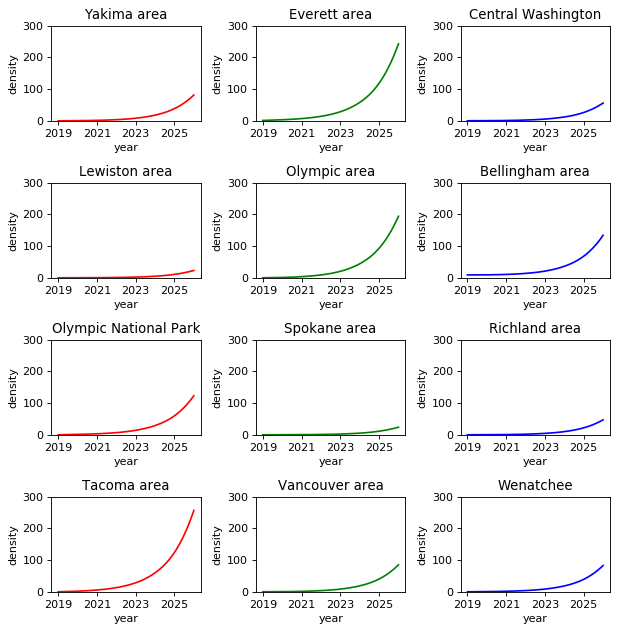

In [86]:
from scipy.interpolate import make_interp_spline
import seaborn as sns
curve

curve_draw = np.array(curve)

t = np.arange(2019, 2019 + len(curve), 1)

plt.figure(figsize=(8,8), dpi=80)
plt.figure(1)
color = ["r", "g", "b"]
name = ["Yakima area", 
        "Everett area", 
        "Central Washington", 
        "Lewiston area", 
        "Olympic area", 
        "Bellingham area", 
        "Olympic National Park", 
        "Spokane area", 
        "Richland area", 
        "Tacoma area", 
        "Vancouver area", 
        "Wenatchee"]

for i in range(0, len(curve[0])) :
    
    x_smooth = np.linspace(t.min(),t.max(),300)
    power_smooth = make_interp_spline(t, curve_draw[:, i])(x_smooth)
    ax = plt.subplot(4, 3, 1 + i)

    plt.ylim((0, 300))
    plt.title(name[i])
    plt.xticks(np.arange(2019, 2027, 2))
    plt.ylabel("density")
    plt.xlabel("year")
    plt.tight_layout()
    ax.plot(x_smooth, power_smooth, color=color[i % len(color)],linestyle = "-")
    
plt.show()

In [80]:
curve

[[0, 1, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0],
 [0.382779288126495,
  3.1657872502951925,
  0.24974527872215851,
  0.09563500515937551,
  0.9868670672902339,
  9.240643027810577,
  1.1436146978557988,
  0.11225624145205018,
  0.18145417290410204,
  1.7940434841542645,
  0.3607883964859631,
  0.5085517493786652],
 [1.3212741616799375,
  6.87241904461752,
  0.860791208768327,
  0.3322821424425053,
  3.472353959167725,
  10.52133173521636,
  3.0756102830991896,
  0.3709288934139171,
  0.661944295864284,
  5.518760697317743,
  1.3169458798617477,
  1.5555278227404945],
 [3.4328441105045813,
  14.030747403338642,
  2.256127236360049,
  0.8843328869226019,
  8.92273102948171,
  13.775019005031508,
  6.748561701457234,
  0.9574888086333213,
  1.801985036714416,
  13.04698707432159,
  3.537550970472531,
  3.770380933645159],
 [8.012391210941784,
  28.43699505783608,
  5.332091571747251,
  2.1232517258792876,
  20.370532284041257,
  20.976868922796875,
  14.095902872004801,
  2.257791623739181,
  4.362

In [9]:
data = pd.read_csv("data/processed_data.csv")

data

,GlobalID,Detection Date,Notes,Lab Status,Lab Comments,Submission Date,Latitude,Longitude,FileName
0,{5AC8034E-5B46-4294-85F0-5B13117EBEFE},2019-12-08 00:00:00,"One dead wasp seen in Blaine, and suspect flyi...",Positive ID,,2020-01-15,48.980994,-122.688503,ATT1.png
1,{5EAD3364-2CA7-4A39-9A53-7F9DCF5D2041},2019-10-30 00:00:00,Hornet specimen sent to WSU,Positive ID,,2020-01-15,48.971949,-122.700941,ATT2.png
2,{13B67BCB-AFCE-4100-AD2B-76EF178BA228},2020-01-15 00:00:00,"Massive loss of bees, decapitated. No hornet s...",Unverified,,2020-01-15,48.939200,-122.661300,ATT3.png
3,{124B9BFA-7F7B-4B8E-8A56-42E067F0F72E},2019-09-19 00:00:00,This was the colony that was found and destroy...,Positive ID,"Thanks for adding this, and the great pictures!",2020-02-04,49.149394,-123.943134,ATT7.png
4,{BBBA5BA0-CAFB-43D3-8F1D-FB2D9CF777E0},2019-08-31 00:00:00,I was cleaning my gutters when I heard a snapp...,Unverified,Thanks for this report. I can't verify it from...,2020-02-14,48.723779,-122.354431,ATT8.png
...,...,...,...,...,...,...,...,...,...
4435,{153C4ACC-72AE-4D87-AA80-4C714417F8C6},2020-10-02 00:00:00,It was about an inch and a quarter in length. ...,Unprocessed,,2020-10-23,47.145673,-122.566734,NaN
4436,{26DDF8E2-DA0C-4F87-A65A-233115BAFCCD},2020-08-29 00:00:00,I was stung several times on the 7th hole ov t...,Unprocessed,,2020-10-23,48.997938,-122.729890,ATT3302.png
4437,{3E50801D-9DBB-43DE-8D32-31CFA88C74D9},2020-10-23 00:00:00,Found dead in humming bird feeder. Silverdale WA,Unprocessed,,2020-10-23,47.651710,-122.692750,ATT3305.png
4438,{9BA7BDD9-01A5-4776-99B0-89FCE08CA53B},2020-10-19 00:00:00,I live on Bainbridge Island on a heavily woode...,Unprocessed,,2020-10-23,47.690120,-122.509780,NaN
